# AirBnB Room Type Prediction

## Ivan Berlim Gonçalves

Responda aos questionamentos que se segue:
- Qual o processo utilizado para definir a sua estratégia de modelagem?


Primeiramente analisei os tipos de dados do dataset para entender quais variáveis estavam disponíveis. Logo percebi que somente algumas variáveis eram realmente relevantes para chegar à variável de interesse `room_type`. Fiz a análise exploratória para entender as variáveis e percebi que teria que lidar com algumas variáveis categóricas e outras numéricas. Para as categóricas escolhi o método One Hot Encoding pois apesar de exigirem um pouco mais de poder computacional, apresentam melhores resultados junto ao modelo. Para as variáveis numéricas fiz uma análise de distribuição e escolhi dois métodos conforme a distribuição. Para a que demonstrou uma distribuição quase normal usei a normalização e para as que apresentaram distribuição caudal escolhi um tratamento que utilizasse uma escala logarítmica para melhor desempenho do modelo.
Para a modelagem escolhi utilizar pipelines de dados pois são de fácil implementação e manipulação, entregando um ótimo desempenho. Como apresentação dos resultados escolhi uma `matriz de confusão` comparando os valores corretos e os valores previstos pelo modelo e a métrica `F1-Score` para avaliação final do modelo.


- Qual o critério utilizado na seleção do modelo final?


Dentre os modelos disponíveis de classificação multiclasse (`one vs one`, `one vs rest` e modelos que já são otimizados para a tarefa) escolhi utilizar o `Random Forest` pois já é um modelo otimizado para tarefas multiclasse e oferece um ótimo resultado para sua demanda computacional. Caso o `Random Forest` não apresentasse os resultados esperados iria tentar algum modelo binário utilizando a técnica one vs one. A escolha do modelo foi muito feliz e como previsto apresentou um resultado excelente - aproximadamente **98,5% de acurácia segundo a metodologia de validação** `F1-score`.


- Você utilizou algum tipo de validação para o modelo? Se sim, qual o processo adotado? Por que escolheu utilizar este método?


Utilizei 4 metodologias, a `ROC AUC`, `precisão`, `recall` e `F1-Score`. Escolhi a `F1-score` pois é mais apropriada para a classificação não balanceada, utiliza a `precisão` e o `recall` como base e por que é tem uma melhor interpretação de seu resultado.


- Quais métricas lhe garantiu que o modelo que você desenvolveu é bom?


Utilizei a métrica `F1-Score` que é a mais apropriada para os tipos de dados trabalhados, porém todas as outras métricas apresentaram resultados excelentes, acima de 98% 

### Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import urllib.request 
import gzip
import shutil
import requests
import os
from io import BytesIO
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (OneHotEncoder, PowerTransformer, StandardScaler)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import f1_score

### Download, extração, leitura do arquivo e Análise Exploratória

In [2]:
# Download do arquivo listings.csv.gz
if os.path.isfile('listings.csv'):
    print('Arquivo já baixado e extraído')
else:
    url = "http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-07-17/data/listings.csv.gz"
    r = requests.get(url, allow_redirects=True)
    open('listings.csv.gz', 'wb').write(r.content)

# Descompactando o arquivo para listings.csv
    with gzip.open('listings.csv.gz', 'rb') as f_in:
        with open('listings.csv', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

Arquivo já baixado e extraído


In [3]:
# Usando a biblioteca pandas e a função 'read_csv' para ler o arquivo listing.csv
df=pd.read_csv("listings.csv")
# Examinando o arquivo
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210717121617,2021-07-17,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,...,4.9,4.76,4.65,NaN,t,1,1,0,0,2.11
1,24480,https://www.airbnb.com/rooms/24480,20210717121617,2021-07-17,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,"The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,...,4.9,4.97,4.58,NaN,f,1,1,0,0,0.88
2,25026,https://www.airbnb.com/rooms/25026,20210717121617,2021-07-17,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,102840,https://www.airbnb.com/users/show/102840,...,4.9,4.81,4.56,NaN,f,2,2,0,0,1.89


In [4]:
# Tamanho do arquivo
df.shape

(23635, 74)

In [5]:
# Contagem de valores da variável de interesse
df['room_type'].value_counts()

Entire home/apt    17172
Private room        5841
Shared room          532
Hotel room            90
Name: room_type, dtype: int64

In [6]:
# Colunas do dataframe
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Text(0.5, 1.0, 'Tipo de acomodações')

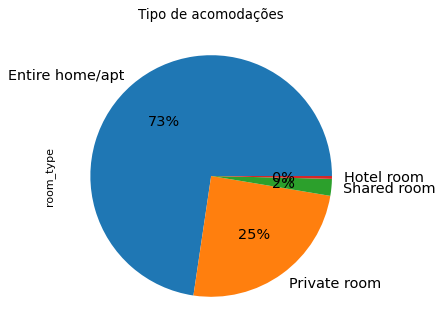

In [7]:
# Plotando gráfico para verificar quantidade de valores únicos na variável room_type
fig = plt.figure(figsize=(5,5), dpi=80)
df['room_type'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13)
plt.title("Tipo de acomodações")

### Seleção de Atributos
Entre 74 colunas, escolhi as que podem ter mais relação com o tipo de acomodação para prever a variável `room_type`

In [8]:
# Criação do dataframe df1 com variáveis de interesse
df1 = df[['room_type', 'property_type', 'accommodates', 'bedrooms', 'beds']].copy()
df1.head()

,room_type,property_type,accommodates,bedrooms,beds
0,Entire home/apt,Entire condominium,5,2.0,2.0
1,Entire home/apt,Entire apartment,2,1.0,1.0
2,Entire home/apt,Entire apartment,2,1.0,2.0
3,Entire home/apt,Entire apartment,2,1.0,1.0
4,Entire home/apt,Entire loft,2,1.0,1.0


In [9]:
# Verificação de valores nulos
df1.isnull().sum()

room_type           0
property_type       0
accommodates        0
bedrooms         1581
beds              228
dtype: int64

In [10]:
# Descarte de 1776 linhas com valores nulos (7,5% do dataset)
df1 = df1.dropna()

In [11]:
# Verificação de valores nulos
df1.isnull().sum()

room_type        0
property_type    0
accommodates     0
bedrooms         0
beds             0
dtype: int64

In [12]:
# Verificação do formato do dataset após exclusão das linhas com valores nulos
df1.shape

(21859, 5)

array([[<AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'beds'}>, <AxesSubplot:>]],
      dtype=object)

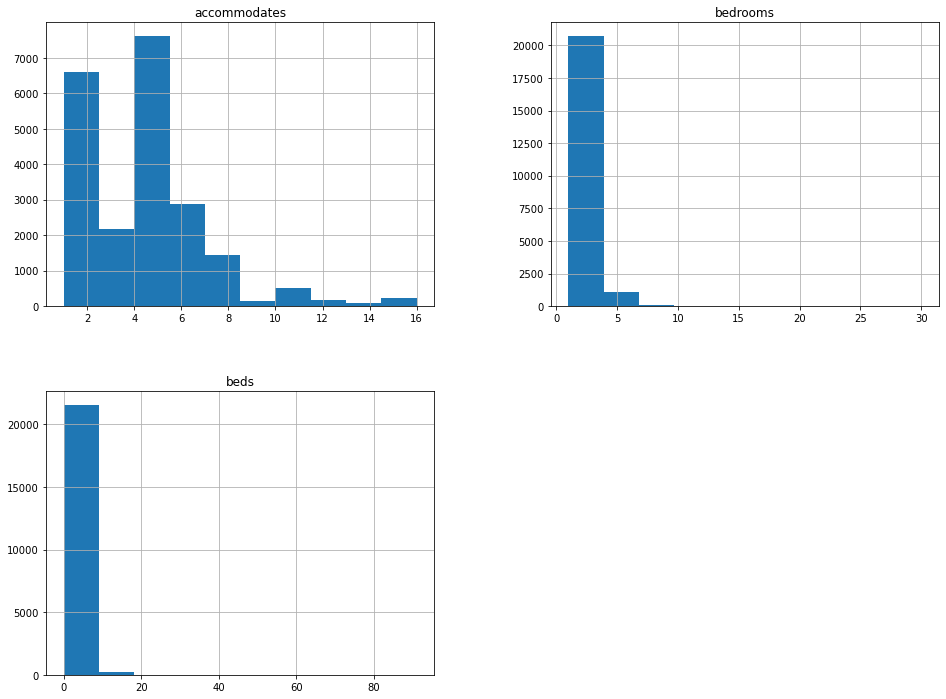

In [13]:
# Verificação da distribuição de valores quantitativos através do histograma
df1.hist(figsize=(16, 12))

As variáveis `Bedrooms` e `beds` apresentam distribuições skewed (enviesadas). Irei usar a transformação logaritmica em ambas para torna-las mais normalmente distribuídas. Para a variável `accommodations` uma simples padronização é suficiente.

<AxesSubplot:>

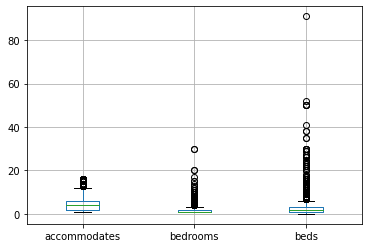

In [14]:
# Distribuição pré tratamento das variáveis qualitativos
df1.boxplot()

In [15]:
# Estatísticas pré tratamento das variáveis qualitativas
df1.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
accommodates,21859.0,4.23,2.52,1.0,2.0,4.0,6.0,16.0
bedrooms,21859.0,1.71,1.09,1.0,1.0,1.0,2.0,30.0
beds,21859.0,2.62,2.33,0.0,1.0,2.0,3.0,91.0


In [16]:
# Soma dos valores únicos dentro da variável property_type
df1['property_type'].value_counts()

Entire apartment             12170
Private room in apartment     3437
Entire condominium            1287
Private room in house         1054
Entire house                   989
                             ...  
Private room in cabin            1
Shared room in farm stay         1
Yurt                             1
Entire vacation home             1
Shared room in townhouse         1
Name: property_type, Length: 85, dtype: int64

### Pré-processamento e treinamento do modelo Random Forest

In [17]:
# Construção das variáveis dependentes e independentes
X, y = df1.drop("room_type", axis=1), df1["room_type"].values.flatten()

# Split de teste e treinamento (1/3 para teste e 2/3 para treinamento)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=118, test_size=0.33, stratify=y
)

In [18]:
# Construção do pré-processador categórico
categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown="ignore")
  )

# Construção do pré-processador numérico
to_log = ["bedrooms", "beds"]
to_scale = ["accommodates"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

# Construção do processador completo
full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale),
    ]
)

# Pipeline final usando o modelo RandomForestClassifier
pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            RandomForestClassifier(max_depth=13),
        ),
    ]
)
# Treinamento do modelo
_ = pipeline.fit(X_train, y_train)

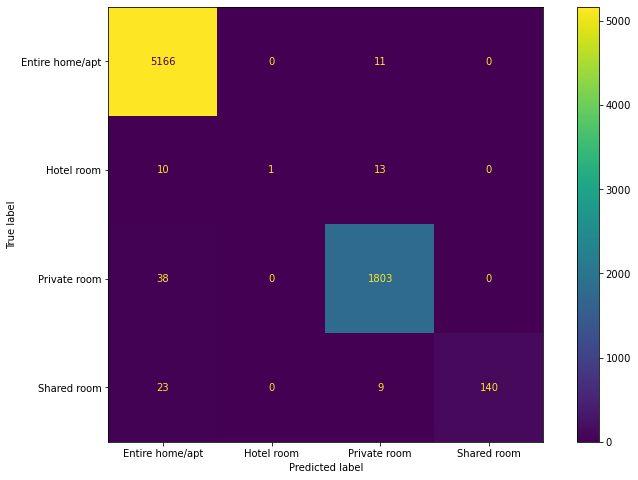

In [19]:
# Instrodução dos dados ao pipeline de pré-processamento e treinamento
y_pred = pipeline.predict(X_test)

# Plot da matriz de confusão
fig, ax = plt.subplots(figsize=(12, 8))

# Criação da matriz de confusão entre y de teste e y previsto pelo modelo
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)

plt.show();

### Avaliação do modelo

#### ROC AUC
É usado principalmente quando queremos medir a performance do classificador para diferenciar cada classe. Isso significa que o ROC AUC é mais adequado para tarefas de classificações balanceadas.

Como exemplo podemos pensar em 100 amostras: classe 1(45), classe 2(30, classe3(25). O Classificador One vs Rest cria 3 classificadores binários, 1 para cada classe e seus ROC AUC são 0.75, 0.68, 0.84 respectivamente. O processo `weighted` leva o imbalanceamento em consideração, atribuindo pesos às classes, somando os valores e dividindo pelo total de amostras. Por exemplo:

ROC AUC (weighted): ((45 * 0.75) + (30 * 0.68) + (25 * 0.84)) / 100 = 0.7515

O score ROC AUC somente é uma boa métrica para ver como o classificador se diferencia entre as classes. Um score alto não necessáriamente significa um modelo melhor.

In [20]:
# Generando scores com .predict_proba
y_pred_probs = pipeline.predict_proba(X_test)

# Calculo ROC_AUC
roc_auc_score(
    y_test, y_pred_probs, multi_class="ovr", average="weighted"
  )

0.999692781338696

In [21]:
# Gerando o ROC AUC em uma classe específica (Entire home/apt)

# Achando um index ideal para a classe
idx = np.where(pipeline.classes_ == "Entire home/apt")[0][0]

# Sem necessidade de ajustar os parâmetros multiclasse e peso
roc_auc_score(y_test == "Entire home/apt", y_pred_probs[:, idx])

0.9997104465590175

### Precision, Recall e F1 Score

<img src="https://miro.medium.com/max/1488/1*XH-bmDiJ50rWfqBR82NOdQ.png" alt="drawing" width="450"/>
<img src="https://miro.medium.com/max/1336/1*KWZHeEuBGhDfw5CTE_PRfQ.png" alt="drawing" width="450"/>
<img src="https://miro.medium.com/max/1266/1*LmttOOk86tXBGlaC_73Xag.png" alt="drawing" width="450"/>

Uma melhor métrica para medir a performance do modelo seria usando a precisão, recall e F1 score. Para casos binários, são fáceis e intuitivos de entender. Para casos multiclasses as 3 métricas são calculadas para cada classe acidional.

* A `precisão` nos diz qual a proporção de predições positivas que são realmente positivas.
A `precisão` tenta responder a pergunta: Qual a proporção de identificações positivas estava realmente correta?
* O `recall` é calculado de maneira similar, é a fração de instâncias relevantes que são recuperadas
O `recall` tenta responder a pergunta: Qual a proporção de positivos verdadeiros foi identificada corretamente?
* Já o `F1-Score` score combina o recall com a precisão de modo que tragam um único número.

In [22]:
# Precisão, recall e F1-Score
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Entire home/apt       0.99      1.00      0.99      5177
     Hotel room       1.00      0.04      0.08        24
   Private room       0.98      0.98      0.98      1841
    Shared room       1.00      0.81      0.90       172

       accuracy                           0.99      7214
      macro avg       0.99      0.71      0.74      7214
   weighted avg       0.99      0.99      0.98      7214



Devido a proporção de `Hotel Rooms`, as vezes ele não aparece nos dados de treino e então pode acontecer de suas métricas serem zero. Porém isto é um caso típico e normal que depende dos dados de treinamento. Por isto as vezes o `classification_report` pode acusar um aviso e atribuir zero a alguma variável.

Dependendo do problema de negócio, podemos escolher uma métrica ou outra. No geral, para problemas de classificação desbalanceada, o F1-score é uma boa métrica, portanto iremos calcular seu valor para podermos ajustar os hiper parâmetros do modelo e incrementar sua acurácia.

In [23]:
# F1 usando pesos através de todas as classes
f1_score(y_test, y_pred, average="weighted")

0.9839155699726553